# Regression Model for National Average Petrol Prices in Australia

This is just a small scale machine learning project giving me a chance to play around with Scikit-Learn. The end result may have some usefulness for anyone who wants to beat the petrol price cycle by being able to predict future prices at the bowser.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression
sns.set() # Prettier Graphs

## Getting the Data

In [2]:
start_date = dt.datetime(2004, 1, 1)
end_date = dt.datetime.now()

In [3]:
brent_df = pdr.get_data_yahoo("BZ=F", start_date, end_date) # Brent Crude oil price data.
brent_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-07-30,76.529999,75.440002,75.849998,75.739998,2575.0,75.739998
2007-07-31,77.169998,75.669998,75.699997,77.050003,3513.0,77.050003
2007-08-01,77.059998,74.860001,77.000000,75.349998,3930.0,75.349998
2007-08-02,76.209999,74.269997,75.220001,75.760002,6180.0,75.760002
2007-08-03,76.000000,74.529999,75.389999,74.750000,4387.0,74.750000


In [4]:
aud_df = pdr.get_data_yahoo("AUDUSD=X", start_date, end_date) # AUDUSD data for fx conversions.
aud_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-05-15,0.768994,0.760688,0.762835,0.767106,0.0,0.767106
2006-05-16,0.772618,0.757576,0.766871,0.759417,0.0,0.759417
2006-05-17,0.767577,0.758725,0.759417,0.764000,0.0,0.764000
2006-05-18,0.764818,0.753012,0.763884,0.757174,0.0,0.757174
2006-05-21,0.756888,0.747105,0.756888,0.753409,0.0,0.753409


In [5]:
# Australian domestic petrol price data.
petrol_df = pd.read_excel(io = "https://www.aip.com.au/sites/default/files/download-files/2022-02/AIP_TGP_Data_11-Feb-2022.xlsx", sheet_name = "Petrol TGP")
petrol_df.head()

,AVERAGE ULP TGPS\n(inclusive of GST),Sydney,Melbourne,Brisbane,Adelaide,Perth,Darwin,Hobart,National\nAverage
0,2004-01-01,86.3,85.1,86.4,87.2,88.5,89.7,87.9,86.4
1,2004-01-02,86.3,85.1,86.4,87.2,88.5,89.7,87.9,86.4
2,2004-01-05,86.4,85.3,86.4,87.2,89.0,89.7,87.9,86.5
3,2004-01-06,86.8,85.6,87.0,87.7,89.1,90.3,88.5,86.9
4,2004-01-07,86.7,85.5,87.0,87.7,89.1,90.3,88.5,86.8


## Preprocessing the Data

In [6]:
cleaning_petrol = petrol_df.copy()
cleaning_brent = brent_df.copy()
cleaning_aud = aud_df.copy()

In [7]:
# Petrol dataframe dates to a datetime object.
cleaning_petrol["AVERAGE ULP TGPS\n(inclusive of GST)"] = pd.to_datetime(cleaning_petrol["AVERAGE ULP TGPS\n(inclusive of GST)"])

In [8]:
cleaning_petrol = cleaning_petrol.set_index(keys = "AVERAGE ULP TGPS\n(inclusive of GST)") # Set the index to a datetime object.
cleaning_petrol = cleaning_petrol.rename_axis(index = "Date") 

In [9]:
cleaning_petrol = cleaning_petrol.asfreq(freq = "b") # Adding missing dates/instances.

In [10]:
cleaning_petrol.isna().sum() # Sum to check missing entries, shouldn't be any.

Sydney               0
Melbourne            0
Brisbane             0
Adelaide             0
Perth                0
Darwin               0
Hobart               0
National\nAverage    0
dtype: int64

In [11]:
# Function to automate the cleaning.

def data_cleaner(dataframe):
    """data_cleaner function takes a dataframe as input and returns another dataframe
    with business day index frequencies with data forward filled."""
    
    data = dataframe
    try:
        data = data.asfreq(freq = "b")
        data = data.fillna(method = "ffill")
        return data
    except:
        return print("Data is required to be a dataframe.")

In [12]:
cleaning_brent = data_cleaner(dataframe = cleaning_brent)
cleaning_aud = data_cleaner(dataframe = cleaning_aud)

In [13]:
index_start = cleaning_aud.shape[0] - cleaning_brent.shape[0]
cleaning_aud = cleaning_aud.iloc[index_start:,:] # Removing some of the data from the aud df so the shapes match with the brent df.

In [14]:
brent_aud = np.divide(cleaning_brent["Close"], cleaning_aud["Close"]) # Brent crude price in AUD.

Note: when doing a rate conversion in this instance the correct approach is division by the exchange rate. The problem can be written as:

$$\frac{USD}{Barrel} \cdot \frac{AUD}{USD}$$

Which is equivalent to:

$$\frac{USD}{Barrel} \div \frac{USD}{AUD}$$

It is confusing in the context of exchange rates because the ticker is written as "AUDUSD" but the actual unit is USD per AUD (The reverse).

In [15]:
end_index = np.argwhere(brent_aud.index == cleaning_petrol.index[-1])[0][0]
start_index_2 = np.argwhere(cleaning_petrol.index == brent_aud.index[0])[0][0]

In [16]:
cleaning_petrol = cleaning_petrol.iloc[start_index_2:,:] # Matching the shapes for final array.
brent_aud = brent_aud.iloc[:(end_index + 1)]

In [17]:
cleaning_petrol["Brent Crude Price (AUD)"] = brent_aud
cleaning_petrol.head()

,Sydney,Melbourne,Brisbane,Adelaide,Perth,Darwin,Hobart,National\nAverage,Brent Crude Price (AUD)
Date,,,,,,,,,
2007-07-30,118.3,118.0,118.6,118.9,118.9,123.1,119.4,118.5,88.896033
2007-07-31,118.1,117.7,118.3,118.5,118.5,122.7,119.1,118.2,90.140796
2007-08-01,118.1,117.7,118.3,118.5,118.5,122.7,119.1,118.2,87.767681
2007-08-02,118.1,117.6,118.2,118.4,118.5,122.7,119.0,118.2,88.305857
2007-08-03,118.6,118.0,118.6,118.9,118.8,123.1,119.3,118.6,87.128598


In [18]:
final_df = cleaning_petrol.copy()

## Training a Linear Regression Model

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = final_df["Brent Crude Price (AUD)"]
y = final_df["National\nAverage"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # Train/test split for the dataset.

In [21]:
x_train_reshaped = x_train.to_numpy().reshape((-1, 1)) # Reshaped data for sklearn.
y_train_reshaped = y_train.to_numpy().reshape((-1, 1))

In [22]:
petrol_mod = LinearRegression()
petrol_mod.fit(X = x_train_reshaped, y = y_train_reshaped)

LinearRegression()

In [23]:
print("R-squared for the model is " + str(petrol_mod.score(X = x_train_reshaped, y = y_train_reshaped)))

R-squared for the model is 0.8586067981364046


In [24]:
from sklearn.metrics import mean_squared_error # For evaluating performance on the training set.

In [25]:
pred_petrol_price = petrol_mod.predict(X = x_train_reshaped)

mse_petrol = mean_squared_error(y_true = y_train_reshaped, y_pred = pred_petrol_price)
rmse_petrol = np.sqrt(mse_petrol)

print("The root mean square error for this linear model is " + str(rmse_petrol) + " cents")

The root mean square error for this linear model is 5.289783630488466 cents


## Visualizing the Linear Model

Linear regression equation: $$ y = B_0 + B_1 \cdot x $$

In [26]:
x_0 = np.linspace(20, 160, num = 100)

yhat = petrol_mod.intercept_[0] + petrol_mod.coef_[0][0]*x_0 # Regression line of best fit.

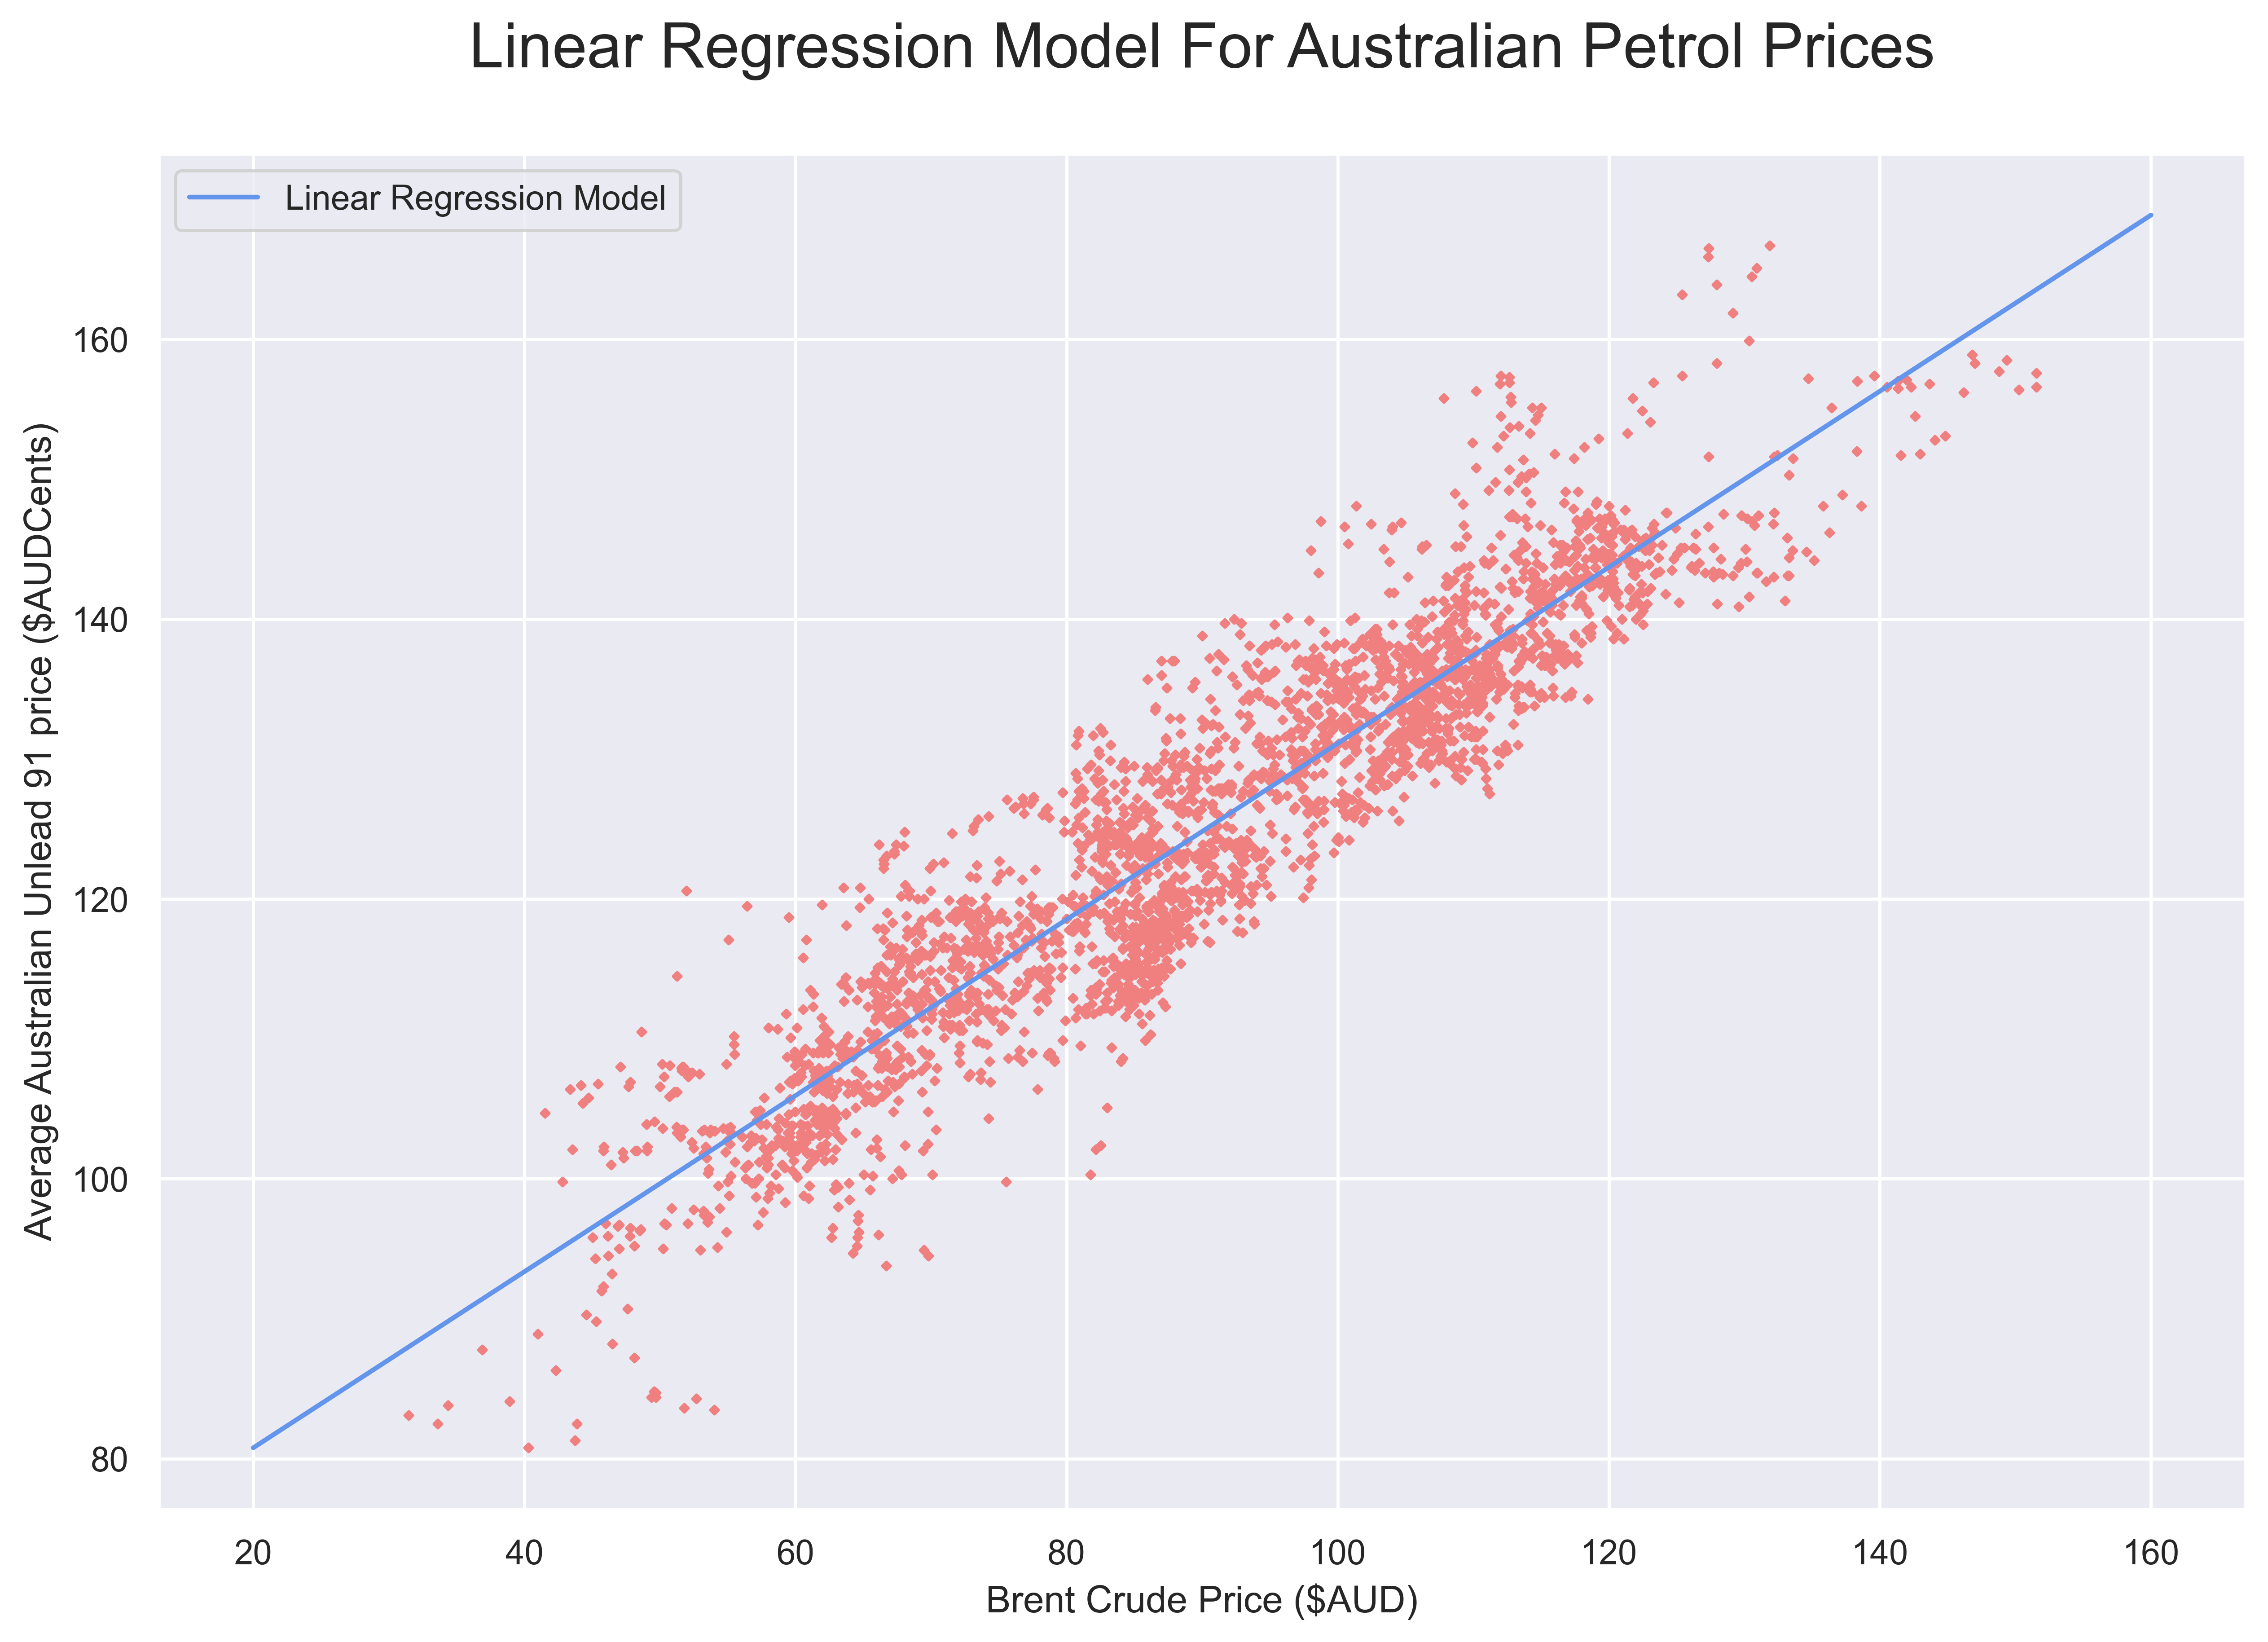

In [27]:
fonts = {"fontname": "Arial"}

plt.figure(figsize = (12, 8), dpi = 500)

plt.scatter(x = x_train_reshaped, y = y_train_reshaped, s = 3, c = "lightcoral", marker = "D")
plt.plot(x_0, yhat, lw = 1.5, ls = "solid", c = "cornflowerblue", label = "Linear Regression Model")
plt.title(label = "Linear Regression Model For Australian Petrol Prices", fontsize = 20, fontdict = fonts, y = 1.05)
plt.xlabel(xlabel = "Brent Crude Price ($AUD)", fontsize = 12, fontdict = fonts)
plt.ylabel(ylabel = "Average Australian Unlead 91 price ($AUDCents)", fontdict = fonts)
plt.legend()

plt.show()

## Training an SVM Regression Model

In [32]:
from sklearn.svm import LinearSVR # Support vector regression.

In [64]:
SVM_petrol_mod = LinearSVR(epsilon = 10) # Arbitrarily set the epsilon hyperparamter to 10.

In [65]:
SVM_petrol_mod.fit(X = x_train_reshaped, y = y_train_reshaped)

C:\Users\Bstaj\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Bstaj\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(epsilon=10)

## Visualizing the SVM Regression Model

In [66]:
SVM_yhat = SVM_petrol_mod.intercept_[0] + SVM_petrol_mod.coef_[0]*x_0 # Regression Equation again.

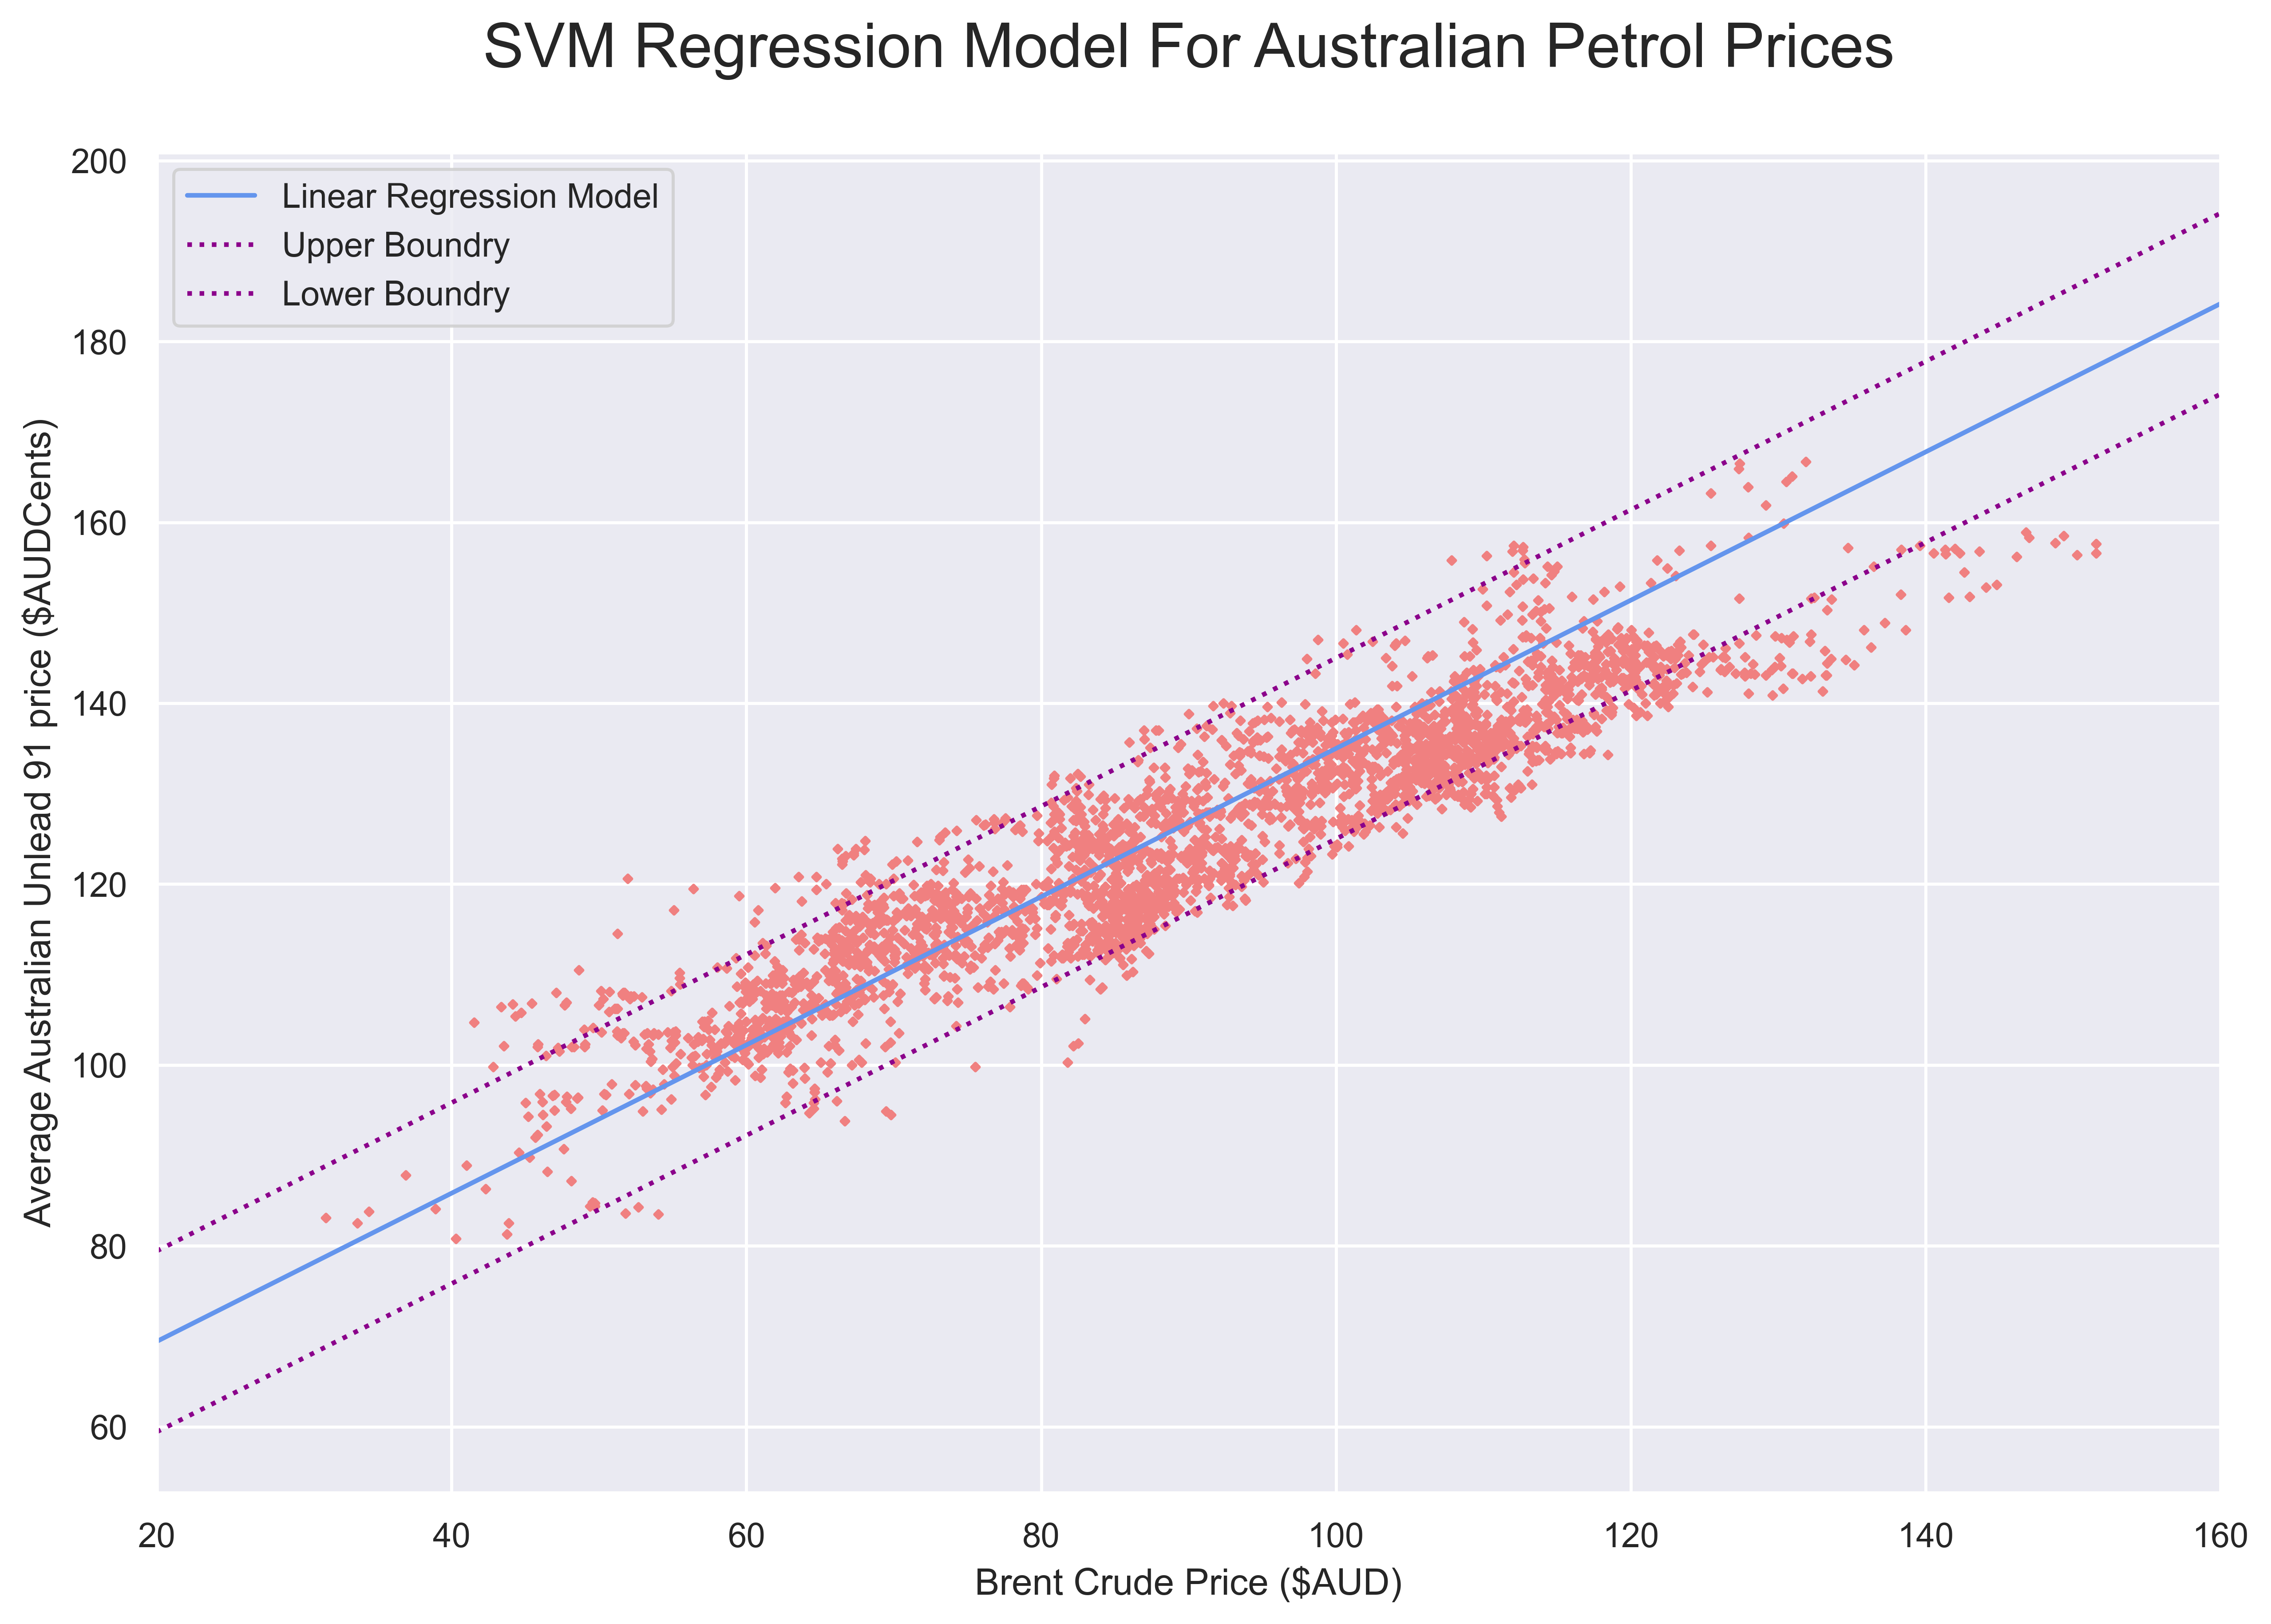

In [74]:
fonts = {"fontname": "Arial"}

plt.figure(figsize = (12, 8), dpi = 500)

plt.scatter(x = x_train_reshaped, y = y_train_reshaped, s = 3, c = "lightcoral", marker = "D")
plt.plot(x_0, SVM_yhat, lw = 1.5, ls = "solid", c = "cornflowerblue", label = "Linear Regression Model")
plt.plot(x_0, SVM_yhat + 10, lw = 1.5, ls = "dotted", c = "darkmagenta", label = "Upper Boundry") # +10 for epsilon hyperparamater.
plt.plot(x_0, SVM_yhat - 10, lw = 1.5, ls = "dotted", c = "darkmagenta", label = "Lower Boundry") # -10 for epsilon hyperparameter.
plt.title(label = "SVM Regression Model For Australian Petrol Prices", fontsize = 20, fontdict = fonts, y = 1.05)
plt.xlabel(xlabel = "Brent Crude Price ($AUD)", fontsize = 12, fontdict = fonts)
plt.ylabel(ylabel = "Average Australian Unlead 91 price ($AUDCents)", fontdict = fonts)
plt.xlim((20, 160))
plt.legend()

plt.show() # Very similar to the linear regression above.

In [69]:
SVR_y_pred = SVM_petrol_mod.predict(X = x_train_reshaped)

In [73]:
SVR_mse = mean_squared_error(y_true = y_train_reshaped, y_pred = SVR_y_pred)
SVR_rsme = np.sqrt(SVR_mse) # Root mean squared error.

print("The root mean squared error for this SVR model is " + str(SVR_rsme)) # Larger than the standard linear regression model.

The root mean squared error for this SVR model is 6.93049388519303


Note: Could run the training data through a decision tree regression model as well, but not going to do that for this project.

## Evaluating the model on the test set

Keeping it simple here, going with the linear regression model. No fine tuning with Grid Search.

In [76]:
x_test_reshaped = x_test.to_numpy().reshape((-1, 1))
y_test_reshaped = y_test.to_numpy().reshape((-1, 1))

In [77]:
test_pred = petrol_mod.predict(X = x_test_reshaped)

In [79]:
final_mse = mean_squared_error(y_true = y_test_reshaped, y_pred = test_pred)
final_rmse = np.sqrt(final_mse)

print("The root mean squared error of the model on the testing data is " + str(final_rmse)) # Differs only slightly from training.

The root mean squared error of the model on the testing data is 5.316048843762472


## Presenting Results

Most people know that oil prices determine what we pay at the bowser, however in Australia many do not realize that we are also at the mercy of FX rates when we pay for petrol. It is very useful for us to have a script which takes Oil price data in USD and converts it into AUD. Which then uses that pricing data for a linear model for national average petrol price prediction.

This linear model performs reasonably well at predicting national average petrol prices, allowing for us to see what price we will be paying in the future (2-3 weeks ahead). This information may be useful for motorists who want to hedge themselves against future price spikes by filling up early, beating the cycle.